<a href="https://colab.research.google.com/github/9659tig/2022S-ML/blob/main/Challenge_201821321_%EC%B5%9C%EC%A4%80%ED%98%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge :: Cartoon Character Classification

만화 이미지를 보고 어떤 캐릭터인지를 분류하는 테스크입니다.  
캐릭터 클래스는 총 10개 입니다.

## Download Data
데이터 출처: https://www.kaggle.com/datasets/volkandl/cartoon-classification

코랩에서 캐글 데이터셋을 바로 불러오기 위해서 kaggle.json 파일이 필요합니다.  
```캐글 본인 계정 페이지``` -> ```Account``` -> ```API``` -> ```Create New API Token```
로 kaggle.json 파일을 다운로드 받을 수 있습니다.

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anjffhgkwl","key":"817aa4a739b9b1e48bc90dd78f7f0056"}'}

In [3]:
ls -1ha kaggle.json # kaggle.json 확인

kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d volkandl/cartoon-classification

100% 11.5G/11.5G [00:51<00:00, 307MB/s]
100% 11.5G/11.5G [00:51<00:00, 240MB/s]


In [6]:
!ls # 데이터셋 다운로드 확인

cartoon-classification.zip  kaggle.json  sample_data


In [7]:
!unzip cartoon-classification.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5099.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY51.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY510.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5100.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5101.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5102.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5103.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5104.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5105.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5106.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5107.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5108.jpg  
  infla

## Load Data

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
import torch.utils.data


In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # prevent truncate error

In [10]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        
    ]),
    "test": transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [11]:
# From https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [43]:
train_data = ImageFolderWithPaths(root = './cartoon_classification/' + "TRAIN", # load train data
                                   transform = image_transforms["train"], 
                                  )
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True) # make train loader

In [ ]:
#train_data = torchvision.datasets.CIFAR10(root='./cartoon_classification/' + "TRAIN", train=True, download=True, transform = image_transforms["train"])
#train_loader= torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cartoon_classification/TRAIN/cifar-10-python.tar.gz to ./cartoon_classification/TRAIN


In [13]:
test_data = ImageFolderWithPaths(root = './cartoon_classification/' + "TEST",
                                   transform = image_transforms["test"] # load test data
                                  )
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False ) # make test loader 
# shuffle false 로 하지 않으면 서버에서 테스트 할 때 문제 생김

In [ ]:
#test_data = torchvision.datasets.CIFAR10(root='./cartoon_classification/' + "TEST",download=True,transform = image_transforms["test"])
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cartoon_classification/TEST/cifar-10-python.tar.gz to ./cartoon_classification/TEST


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

pre_process = ImageDataGenerator(rotation_range = 30, width_shift_range = 0.2, shear_range=0.2, horizontal_flip=True)
augment_ratio = 1.5
augment_size = int(augment_ratio* train_loader.shape[0])

randidx = np.random.randint(train_loader.shape[0])

In [44]:
classes = train_data.class_to_idx # class name
classes

{'Familyguy': 0,
 'Gumball': 1,
 'Tsubasa': 2,
 'adventure_time': 3,
 'catdog': 4,
 'pokemon': 5,
 'smurfs': 6,
 'southpark': 7,
 'spongebob': 8,
 'tom_and_jerry': 9}

## Show Example Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


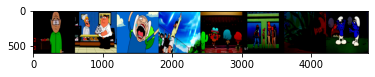


southpark Familyguy adventure_time Tsubasa Gumball pokemon smurfs smurfs


In [45]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels, paths = dataiter.next()

batch_size = 8

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print()
labels = labels.tolist()
print(' '.join(f'{list(classes.keys())[list(classes.values()).index(j)]}' for j in labels))

## Define a Convolutional Neural Network

Modified https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [46]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3) # in_channel, out_channel, kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 3, 5)
        self.fc1 = nn.Linear(64827, 5000)
        self.fc2 = nn.Linear(5000, 2500)
        self.fc3 = nn.Linear(2500, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 10)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu") # Use GPU if it's available

In [48]:
net = Net() # define the network
net = net.to(device) # send the network to the device

## Define a Loss function and optimizer

In [49]:
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # optimizer

## Train the Network

In [50]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, paths = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training') # colab pro+ 기준, 한 epoch 당 35분 소요

  0%|          | 0/14953 [00:00<?, ?it/s]

[1,  2000] loss: 1.056
[1,  4000] loss: 0.228
[1,  6000] loss: 0.107
[1,  8000] loss: 0.064
[1, 10000] loss: 0.051
[1, 12000] loss: 0.035
[1, 14000] loss: 0.037
Finished Training


## Save the Network

In [51]:
# save the trained model
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

## Load the Network

In [52]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

## Testing & Making a Submission File

In [53]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

image_id = []
predicted_label = []
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader,0)):
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        image_id.append(paths)
        predicted_label.append(predicted.item())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test_loader.dataset)} test images: {100 * correct // total} %')

  0%|          | 0/18110 [00:00<?, ?it/s]

Accuracy of the network on the 18110 test images: 57 %


In [54]:
submit_sol = pd.DataFrame(list(zip(image_id, predicted_label)), columns=['id','predicted'])

In [55]:
submit_sol

,id,predicted
0,(./cartoon_classification/TEST/Familyguy/famil...,0
1,(./cartoon_classification/TEST/Familyguy/famil...,2
2,(./cartoon_classification/TEST/Familyguy/famil...,2
3,(./cartoon_classification/TEST/Familyguy/famil...,2
4,(./cartoon_classification/TEST/Familyguy/famil...,2
...,...,...
18105,(./cartoon_classification/TEST/tom_and_jerry/T...,9
18106,(./cartoon_classification/TEST/tom_and_jerry/T...,9
18107,(./cartoon_classification/TEST/tom_and_jerry/T...,9
18108,(./cartoon_classification/TEST/tom_and_jerry/T...,9


In [56]:
import os

def clean_path(path):
  cleaned_path = os.path.normpath(path)
  cleaned_path = path.split(os.sep)
  new_path = cleaned_path[3] +'/' + cleaned_path[4] # cartoon name/xx.jpg
  return new_path

In [57]:
path_list = []
for i in range(len(submit_sol)):
  out = clean_path(submit_sol.iloc[i][0][0])
  path_list.append(out)

submit_sol['id'] = path_list

In [58]:
submit_sol.to_csv('test_result.csv', index=False)  # submit this test_result.csv to kaggle server

In [60]:
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

img_width, img_height = 250, 350 #
train_data_dir = r'./cartoon_classification/TRAIN'
validation_data_dir = r'./cartoon_classification/TEST/'

batch_size = 8


train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 119617 images belonging to 10 classes.
Found 18110 images belonging to 10 classes.


In [63]:
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
numberOfClass=10
batch_size = 8
epochs=8


vgg = VGG19(include_top= False, weights = "imagenet", input_shape=(250,350,3))
vgg_layer_list = vgg.layers

model = Sequential ()

for layer in vgg_layer_list:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False
    
    
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

opt = Adam(lr=0.001)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])


hist = model.fit_generator(
        generator=train_generator,
        steps_per_epoch = 1500,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps = 220,
        shuffle=True)

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 250, 350, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 350, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 175, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 175, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 175, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 87, 128)       0         
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/8
1500/1500 [==============================] - 286s 184ms/step - loss: 1.1744 - accuracy: 0.6351 - val_loss: 0.9072 - val_accuracy: 0.6784
Epoch 2/8
1500/1500 [==============================] - 272s 181ms/step - loss: 0.6327 - accuracy: 0.7871 - val_loss: 0.6850 - val_accuracy: 0.7869
Epoch 3/8
1500/1500 [==============================] - 273s 182ms/step - loss: 0.5328 - accuracy: 0.8249 - val_loss: 0.6719 - val_accuracy: 0.7864
Epoch 4/8
1500/1500 [==============================] - 272s 182ms/step - loss: 0.4923 - accuracy: 0.8392 - val_loss: 0.7380 - val_accuracy: 0.7631
Epoch 5/8
1500/1500 [==============================] - 271s 181ms/step - loss: 0.4729 - accuracy: 0.8458 - val_loss: 0.6005 - val_accuracy: 0.8142
Epoch 6/8
1500/1500 [==============================] - 269s 179ms/step - loss: 0.5056 - accuracy: 0.8361 - val_loss: 0.6588 - val_accuracy: 0.7705
Epoch 7/8
1500/1500 [==============================] - 271s 181ms/step - loss: 0.4406 - accuracy: 0.8560 - val_loss: 0